In [43]:
import pandas as pd
import numpy as np
import os as os
from IPython.display import display
from sklearn.linear_model import PoissonRegressor, TweedieRegressor, Perceptron, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE

### Load data

In [44]:
dfs_train = {}
dfs_test = {}

In [45]:
for root, directory, files in os.walk("data/train_preprocessed", topdown=False):
    if files:
        for file in files:
            dfs_train[file[:-4]] = pd.read_csv(f"{root}/{file}")
for root, directory, files in os.walk("data/test_preprocessed", topdown=False):
    if files:
        for file in files:
            dfs_test[file[:-4]] = pd.read_csv(f"{root}/{file}")
            dfs_test[file[:-4]].drop(columns=["Target_clas", "Target_regr"], inplace=True)

In [46]:
def impute_nan_values(dfs):
    for df in dfs.values():
        for col in df.columns:
            if df[col].dtype == np.float64 or df[col].dtype == np.int64:
                df[col] = df.groupby("season")[col].transform(lambda x: x.fillna(x.mean()))
        df.dropna(inplace=True)
impute_nan_values(dfs_train)
impute_nan_values(dfs_test)

In [47]:
# validation set

dfs_valid_reg_X = {}
dfs_valid_reg_y = {}
dfs_train_reg_X = {}
dfs_train_reg_y = {}
# dfs_valid_clas_X = {}
# dfs_valid_clas_y = {}
# dfs_train_clas_X = {}
# dfs_train_clas_y = {}


cols_to_drop = ['FTHG', 'FTAG', 'MatchTeams', 'SameHomeTeam', 'Target_regr', 'Target_clas']

for country in dfs_train:
    # dfs_valid_reg_y[country[3:]] = dfs_train[country][dfs_train[country]["Target_regr"] > 0]
    # dfs_valid_reg_X[country[3:]] = dfs_train[country][dfs_train[country]["Target_regr"] > 0]
    # 
    # dfs_train_reg_y[country[3:]] = dfs_train[country][dfs_train[country]["Target_regr"] > 0]
    # dfs_train_reg_X[country[3:]] = dfs_train[country][dfs_train[country]["Target_regr"] > 0]
    
    dfs_valid_reg_y[country[3:]] = dfs_train[country][dfs_train[country]["season"] == 21]["Target_regr"]
    dfs_valid_reg_X[country[3:]] = dfs_train[country][dfs_train[country]["season"] == 21].drop(columns=cols_to_drop)

    dfs_train_reg_y[country[3:]] = dfs_train[country][dfs_train[country]["season"] > 5]
    dfs_train_reg_X[country[3:]] = dfs_train[country][dfs_train[country]["season"] > 5]
    
    dfs_train_reg_y[country[3:]] = dfs_train_reg_y[country[3:]][dfs_train_reg_y[country[3:]]["season"] != 21]["Target_regr"]
    dfs_train_reg_X[country[3:]] = dfs_train_reg_X[country[3:]][dfs_train_reg_X[country[3:]]["season"] != 21].drop(columns=cols_to_drop)

    # dfs_train_clas_y[country[3:]] = dfs_train[country][dfs_train[country]["season"] != 21]["Target_clas"]
    # dfs_train_clas_X[country[3:]] = dfs_train[country][dfs_train[country]["season"] != 21].drop(columns=cols_to_drop)
    # 
    # dfs_valid_clas_y[country[3:]] = dfs_train[country][dfs_train[country]["season"] == 21]["Target_clas"]
    # dfs_valid_clas_X[country[3:]] = dfs_train[country][dfs_train[country]["season"] == 21].drop(columns=cols_to_drop)

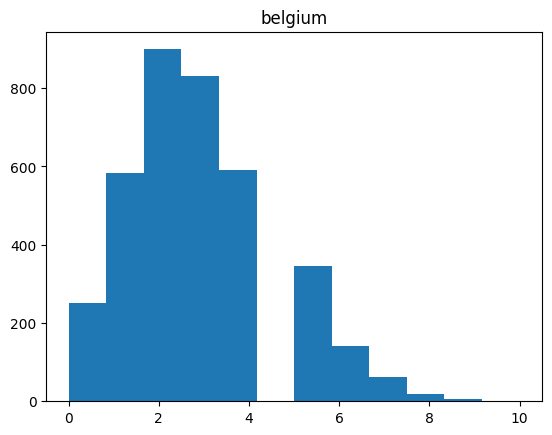

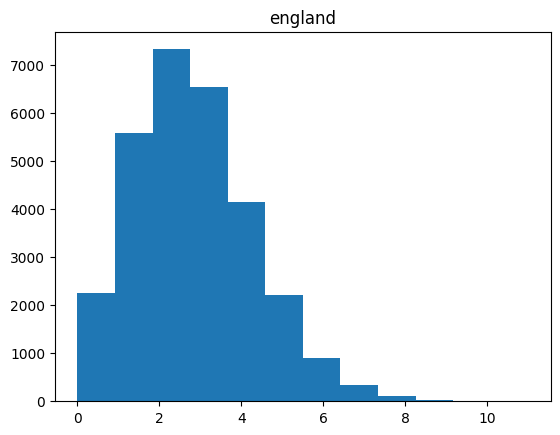

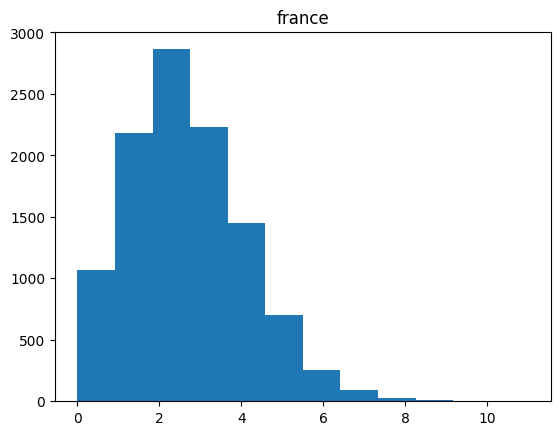

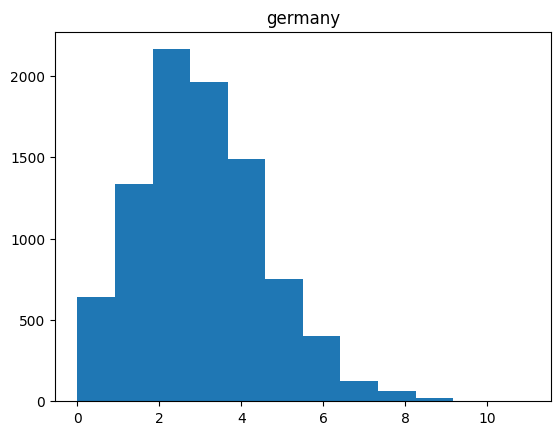

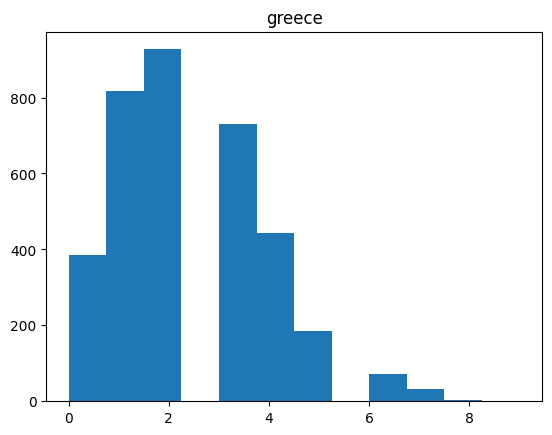

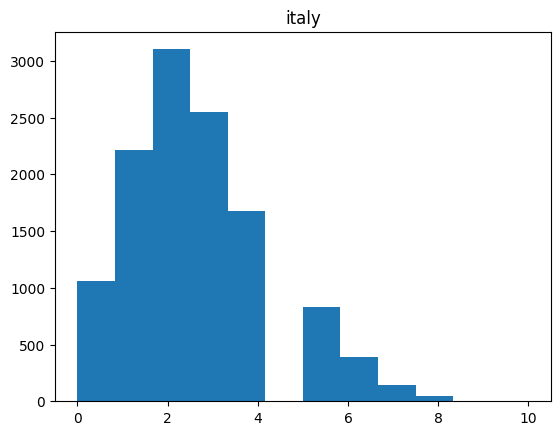

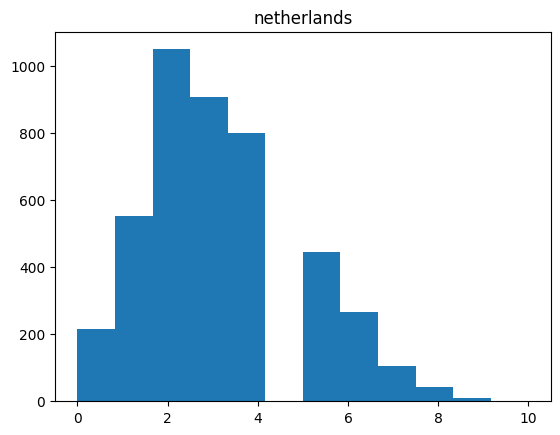

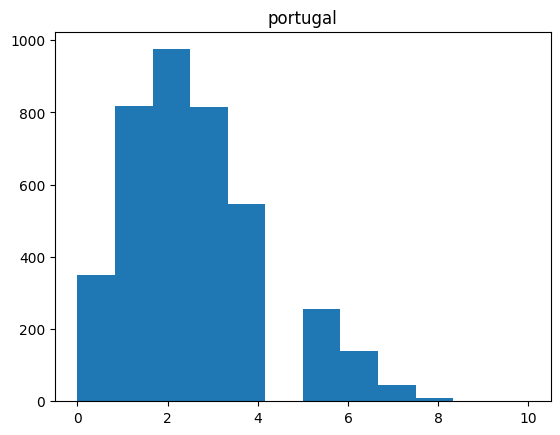

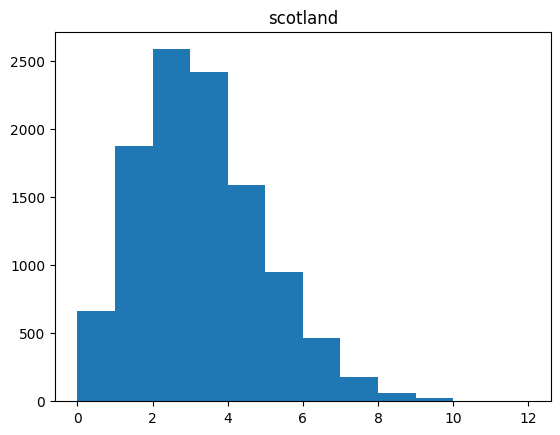

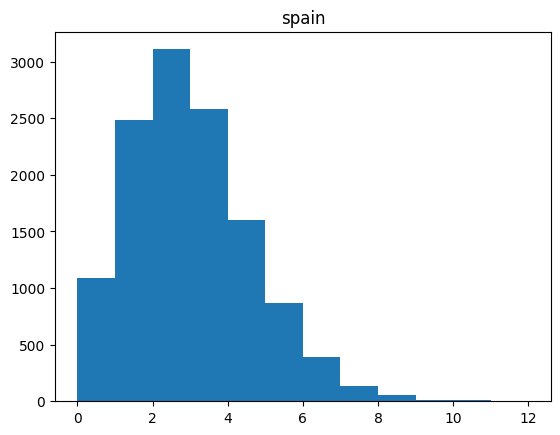

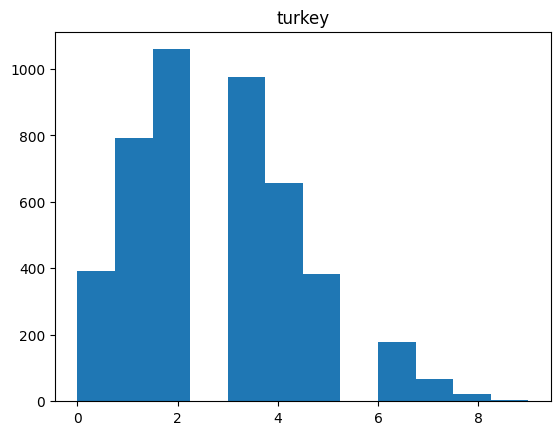

2.426353027657815

In [48]:
# obraski
import matplotlib.pyplot as plt 

a = pd.DataFrame
for country in dfs_train_reg_y:
    a = dfs_train_reg_y[country].value_counts()
    plt.hist(x=dfs_train_reg_y[country], bins=12)
    plt.title(country)
    plt.show()


dfs_train_reg_y['france'].mean()

In [49]:
for country in bl_forests:
    try:
        dfs_valid_reg_X[country].drop(columns=['Avg_bookie_prediction'], axis=1, inplace=True)
        dfs_train_reg_X[country].drop(columns=['Avg_bookie_prediction'], axis=1, inplace=True)
    except:
        print("hmm")

hmm
hmm
hmm
hmm
hmm
hmm
hmm
hmm
hmm
hmm
hmm


### Regression task


baseline model


In [50]:
bl_forests = {}
p_regressors = {}
# tw_forests = {}
# perceptrons = {}
log_regressors = {}
class_forests = {}
ada_regressors = {}
pois_for_ada = {}
ada_pois = {}
bag_regressors = {}
grad_regressors = {}

In [51]:
for country in dfs_train_reg_X:
    bl_forests[country] = RandomForestRegressor(n_estimators=186, criterion="squared_error", max_depth=10)
    p_regressors[country] = PoissonRegressor(max_iter=100, solver='newton-cholesky')
    # tw_forests[country] = TweedieRegressor(power=3, solver='newton-cholesky')
    # perceptrons[country] = Perceptron()
    log_regressors[country] = LogisticRegression(solver='newton-cholesky', random_state=42)
    class_forests[country] = RandomForestClassifier(n_estimators=186, max_depth=10)
    ada_regressors[country] = AdaBoostRegressor(loss='square', random_state=42) # try boosted poisson and voting
    pois_for_ada[country] = PoissonRegressor(max_iter=100, solver='newton-cholesky')
    ada_pois[country] = AdaBoostRegressor(estimator=pois_for_ada[country], loss='square', random_state=42)
    bag_regressors[country] = BaggingRegressor(bootstrap=False, random_state=42)
    grad_regressors[country] = GradientBoostingRegressor(random_state=42)
    

In [52]:
# dfs_train_reg_X['england'].head()


In [53]:
for country in bl_forests:
    print("fitting ", country)
    bl_forests[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    p_regressors[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    # tw_forests[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    # perceptrons[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    log_regressors[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    class_forests[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    ada_regressors[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    ada_pois[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    bag_regressors[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    grad_regressors[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])

fitting  belgium
fitting  england
fitting  france
fitting  germany
fitting  greece
fitting  italy
fitting  netherlands
fitting  portugal
fitting  scotland
fitting  spain
fitting  turkey


In [54]:
for country in bl_forests:
    # print("predicting ", country)
    bl_prediction = bl_forests[country].predict(dfs_valid_reg_X[country])
    print("baseline forest mse of ", country, ":\t", MSE(bl_prediction, dfs_valid_reg_y[country]))
    pr_prediction = p_regressors[country].predict(dfs_valid_reg_X[country])
    print("poisson regressor MSE of ", country, ":\t", MSE(pr_prediction, dfs_valid_reg_y[country]))
    # tw_prediction = tw_forests[country].predict(dfs_valid_reg_X[country])
    # print("tweedie regression MSE ", country, ": ", MSE(tw_prediction, dfs_valid_reg_y[country]))
    # per_prediction = perceptrons[country].predict(dfs_valid_reg_X[country])
    # print("perceptron model mse of ", country, ":\t", MSE(per_prediction, dfs_valid_reg_y[country]))
    log_prediction = log_regressors[country].predict(dfs_valid_reg_X[country])
    print("logistic regression mse of ", country, ":\t", MSE(log_prediction, dfs_valid_reg_y[country]))
    cl_prediction = class_forests[country].predict(dfs_valid_reg_X[country])
    print("classification model mse of ", country, ":\t", MSE(cl_prediction, dfs_valid_reg_y[country]))
    ada_prediction = ada_regressors[country].predict(dfs_valid_reg_X[country])
    print("ada boost model mse of ", country, ":\t", MSE(ada_prediction, dfs_valid_reg_y[country]))
    ada_pois_prediction = grad_regressors[country].predict(dfs_valid_reg_X[country])
    print("ada poisson model mse of ", country, ":\t", MSE(ada_pois_prediction, dfs_valid_reg_y[country]))
    bag_prediction = bag_regressors[country].predict(dfs_valid_reg_X[country])
    print("bagging regressor mse of ", country, ":\t", MSE(bag_prediction, dfs_valid_reg_y[country]))
    grad_prediction = grad_regressors[country].predict(dfs_valid_reg_X[country])
    print("gradient boost mse of ", country, ":\t", MSE(grad_prediction, dfs_valid_reg_y[country]))
    print("----------------------")
    print(min([MSE(bl_prediction, dfs_valid_reg_y[country]),
               MSE(pr_prediction, dfs_valid_reg_y[country]),
               # MSE(tw_prediction, dfs_valid_reg_y[country]),
               # MSE(per_prediction, dfs_valid_reg_y[country]),
               MSE(log_prediction, dfs_valid_reg_y[country]),
               MSE(cl_prediction, dfs_valid_reg_y[country]),
               MSE(ada_prediction, dfs_valid_reg_y[country]),
               MSE(bag_prediction, dfs_valid_reg_y[country]),
               MSE(grad_prediction, dfs_valid_reg_y[country])
    ]))
    print("----------------------")

baseline forest mse of  belgium :	 3.9903081609942332
poisson regressor MSE of  belgium :	 2.656771761053219
logistic regression mse of  belgium :	 2.729096989966555
classification model mse of  belgium :	 2.8729096989966556
ada boost model mse of  belgium :	 3.8729413048119117
ada poisson model mse of  belgium :	 4.114509696038919
bagging regressor mse of  belgium :	 6.894615384615384
gradient boost mse of  belgium :	 4.114509696038919
----------------------
2.656771761053219
----------------------
baseline forest mse of  england :	 2.5360204059367093
poisson regressor MSE of  england :	 2.526058175548578
logistic regression mse of  england :	 3.087719298245614
classification model mse of  england :	 2.869674185463659
ada boost model mse of  england :	 5.433117404910551
ada poisson model mse of  england :	 2.549058313187919
bagging regressor mse of  england :	 5.23618045112782
gradient boost mse of  england :	 2.549058313187919
----------------------
2.526058175548578
----------------

random search is very slow and kinda useless


In [55]:
param_grid = {
    'n_estimators':[i for i in range(50,200)],
    'min_samples_split':[i for i in range(2, 50)],
    'max_depth':[i for i in range(3, 100)]
}

rs_estimators = {}
rs_forests = {}
rs_best = {}
rs_best_estims = {}

In [56]:
for country in bl_forests:
    rs_estimators[country] = RandomForestRegressor(random_state=42)

In [57]:
for country in dfs_train_reg_X:
    print("random searching", country)
    rs_forests[country] = RandomizedSearchCV(estimator=rs_estimators[country], param_distributions=param_grid,  n_iter=3, cv=3, random_state=42, error_score='raise')

random searching belgium
random searching england
random searching france
random searching germany
random searching greece
random searching italy
random searching netherlands
random searching portugal
random searching scotland
random searching spain
random searching turkey


In [ ]:
for country in rs_forests:
    rs_forests[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    rs_best[country] = rs_forests[country].best_params_
    print("best params for country", country, ": ", rs_best[country])
    rs_best_estims[country] = rs_forests[country].best_estimator_

best params for country belgium :  {'n_estimators': 58, 'min_samples_split': 47, 'max_depth': 19}


In [ ]:
for country in rs_forests:
    preds = rs_best_estims[country].predict(dfs_valid_reg_X[country])
    print("Validation MSE of country ", country, " with random search params: ", MSE(dfs_valid_reg_y[country], preds))

*repeat with boosting?*